# Configs e Imports


In [ ]:
# instalar para o kaggle
%pip install sentence-transformers datasets accelerate

In [ ]:
# BIBLIOTECAS DE ANÁLISE DE DADOS E NUMÉRICAS
import numpy as np
import pandas as pd

# BIBLIOTECAS DE VISUALIZAÇÃO DE DADOS
import matplotlib.pyplot as plt
import seaborn as sns

# BIBLIOTECAS DE MACHINE LEARNING E ESTATÍSTICA
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# BIBLIOTECA PRINCIPAL DE DEEP LEARNING (PYTORCH)
import torch

# BIBLIOTECA DE NLP (SENTENCE TRANSFORMERS)
from sentence_transformers import (
    InputExample,  # Estrutura para encapsular um exemplo de treino (par de frases + label).
    SentenceTransformer,  # Classe principal para carregar e usar modelos SBERT.
    losses,  # Módulo com as funções de perda (ex: CosineSimilarityLoss).
    util,  # Funções utilitárias (ex: util.cos_sim para similaridade).
)
from sentence_transformers.evaluation import (
    EmbeddingSimilarityEvaluator,
)  # Classe para avaliar a performance durante o treino.
from sentence_transformers.similarity_functions import (
    SimilarityFunction,
)  # Enum para funções de similaridade (ex: COSINE).
from sentence_transformers.trainer import (
    SentenceTransformerTrainer,
)  # API de alto nível para gerenciar o treinamento.
from sentence_transformers.training_args import (
    SentenceTransformerTrainingArguments,
)  # Argumentos e configurações para o Trainer.

# Define se o código rodará em GPU (cuda) ou CPU, otimizando a performance.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# EDA


Arquivo 'kaggle_train.csv' carregado com sucesso!

Dimensões do DataFrame: (6040, 3)

Colunas disponíveis: ['sentence1', 'sentence2', 'similarity_score']

Primeira linha do DataFrame:
                                 sentence1  \
0  The cat is attacking a corn husk broom.   

                                      sentence2  similarity_score  
0  Grey and white cat sitting in bathroom sink.               0.8  

Valores nulos por coluna:
sentence1           0
sentence2           0
similarity_score    0
dtype: int64

Distribuição das classes arredondadas:
similarity_score
0.0     735
1.0     853
2.0    1043
3.0    1365
4.0    1433
5.0     611
Name: count, dtype: int64


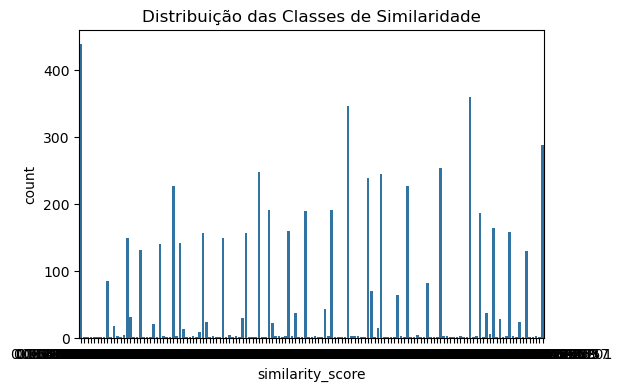

In [ ]:
caminho_train = "/kaggle/input/2025-2-similaridade-de-sentencas/train.csv"
caminho_test = "/kaggle/input/2025-2-similaridade-de-sentencas/test.csv"

df = pd.read_csv(caminho_train)
print("Arquivo train.csv carregado com sucesso!")

# Exibir as primeiras linhas e informações básicas
print("\nDimensões do DataFrame:", df.shape)
print("\nColunas disponíveis:", df.columns.tolist())
print("\nPrimeiras 3 linhas do DataFrame:")
print(df.head(3))

print("\nValores nulos por coluna:")
print(df.isnull().sum())

# Análise de Balanceamento das Classes
print("\nDistribuição das classes:")
print(df["similarity_score"].value_counts().sort_index())

print("\nEstatísticas do similarity_score:")
print(df["similarity_score"].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df["similarity_score"], bins=20, alpha=0.7)
plt.title("Distribuição dos Scores de Similaridade")
plt.xlabel("Similarity Score")
plt.ylabel("Frequência")

plt.subplot(1, 2, 2)
sns.boxplot(y=df["similarity_score"])
plt.title("Boxplot dos Scores de Similaridade")
plt.show()

# Preparando Dados para o SBERT


In [ ]:
# Separar X e y
X = df[["sentence1", "sentence2"]]
y = df["similarity_score"]

# Separar dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os scores para o intervalo [0, 1]
y_train_norm = y_train / 5.0

# Verificar os resultados
print("\nDimensões do conjunto de treino:", X_train.shape)
print("Dimensões do conjunto de validação:", X_val.shape)
print("\nDistribuição das classes no conjunto de treino:")
print(y_train.value_counts().sort_index())
print("\nDistribuição das classes no conjunto de validação:")
print(y_val.value_counts().sort_index())

# Preparando Dados para o SBERT
train_examples = [
    InputExample(texts=[s1, s2], label=float(label))
    for s1, s2, label in zip(X_train["sentence1"], X_train["sentence2"], y_train_norm)
]

val_examples = [
    InputExample(texts=[s1, s2], label=float(label))
    for s1, s2, label in zip(X_val["sentence1"], X_val["sentence2"], y_val)
]

print(f"\nNúmero de exemplos de treino: {len(train_examples)}")
print(f"Número de exemplos de validação: {len(val_examples)}")

# Configuração do Modelo SBERT


In [ ]:
# Configurar modelo
model = SentenceTransformer("all-MiniLM-L6-v2")
model = model.to(device)

# Configurar loss function
train_loss = losses.CosineSimilarityLoss(model=model)

# Configurar avaliador
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=[example.texts[0] for example in val_examples],
    sentences2=[example.texts[1] for example in val_examples],
    scores=[example.label for example in val_examples],
    main_similarity=SimilarityFunction.COSINE,
    show_progress_bar=True,
    name="validation",
)

print("Modelo e avaliador configurados com sucesso!")

# Treinamento do Modelo


In [ ]:
num_epochs = 4
batch_size = 16

In [ ]:
# Configurar argumentos de treinamento
args = SentenceTransformerTrainingArguments(
    output_dir="./results",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    fp16=True,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_validation_spearman_cosine",
    greater_is_better=True,
    run_name="sbert-similarity-training",
)

# Configurar trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_examples,
    eval_dataset=val_examples,
    loss=train_loss,
    evaluator=dev_evaluator,
)

print("Trainer configurado. Iniciando treinamento...")

# Treinar o modelo
trainer.train()

print("Treinamento concluído!")

# Avaliação do Modelo


In [ ]:
# Salvar o modelo treinado
caminho_modelo = "./fine-tuned-sbert-model"
model.save(caminho_modelo)
print("Modelo salvo!")

# Avaliar no conjunto de validação
print("\nAvaliação no conjunto de validação:")
val_score = dev_evaluator(model)
print(f"Validation Score: {val_score:.4f}")

print("\nIniciando avaliação manual detalhada...")

# Gerar embeddings para as sentenças de validação
val_embeddings1 = model.encode(
    [example.texts[0] for example in val_examples],
    show_progress_bar=True,
    device=device,
)
val_embeddings2 = model.encode(
    [example.texts[1] for example in val_examples],
    show_progress_bar=True,
    device=device,
)

# Calcular similaridade coseno
similarities = util.cos_sim(val_embeddings1, val_embeddings2)

val_predictions = [similarities[i][i] for i in range(len(similarities))]

# Valores verdadeiros
val_true = np.array([example.label for example in val_examples])
val_true_norm = val_true / 5.0

# Métricas
mse = mean_squared_error(val_true_norm, val_predictions)
mae = mean_absolute_error(val_true_norm, val_predictions)

# Calcule as correlações
pearson_corr = np.corrcoef(val_true, val_predictions)[0, 1]
spearman_corr, _ = spearmanr(val_true, val_predictions)


print("\nMétricas de Validação Detalhadas:")
print(f"MSE (comparando 0-1 vs 0-1): {mse:.4f}")
print(f"MAE (comparando 0-1 vs 0-1): {mae:.4f}")
print("-" * 30)
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation (manual): {spearman_corr:.4f}")

# Teste no Conjunto de Teste


In [ ]:
caminho_submissao = "./submission.csv"

print(f"Lendo dados de teste de '{caminho_test}'...")
df_test = pd.read_csv(caminho_test)

# Extrair as sentenças e os índices para o arquivo de submissão
test_sentences1 = df_test["sentence1"].tolist()
test_sentences2 = df_test["sentence2"].tolist()
test_indexes = df_test.iloc[:, 0].tolist()
print(f"Encontrados {len(df_test)} exemplos no conjunto de teste.")


# --- 4. Gerar Predições ---
print("Gerando embeddings e calculando similaridade...")

# Gerar embeddings (o modelo processa tudo em lote, é muito eficiente)
embeddings1 = model.encode(test_sentences1, show_progress_bar=True, device=device)
embeddings2 = model.encode(test_sentences2, show_progress_bar=True, device=device)

# Calcular similaridade de cosseno para todos os pares de uma vez
test_similarities = util.cos_sim(embeddings1, embeddings2)

# As predições são a diagonal da matriz de similaridade (score de 0-1)
predictions_normalized = [
    test_similarities[i][i] for i in range(len(test_similarities))
]
print("Predições na escala 0-1 calculadas.")

# O modelo prevê na escala 0-1. O arquivo de submissão precisa da escala 0-5.
print("Reescalonando predições para a escala 0-5...")
predictions_rescaled = np.array(predictions_normalized) * 5.0

# Garante que nenhum valor fique fora da faixa 0-5
predictions_rescaled = np.clip(predictions_rescaled, 0, 5)


# Criar e Salvar o Arquivo de Submissão
print("Criando o DataFrame de submissão...")
submission_df = pd.DataFrame(
    {"INDEX": test_indexes, "PREDICTIONS": predictions_rescaled}
)

# Salvar no formato CSV sem o índice do pandas
submission_df.to_csv(caminho_submissao, index=False)
print(f"Arquivo de submissão salvo com sucesso em: {caminho_submissao}")

# Verificação final
print("\nPrimeiras 5 linhas do arquivo de submissão:")
print(submission_df.head())

In [ ]:
# Visualizar resultados
plt.figure(figsize=(18, 5))

# Gráfico 1: Scatter Plot (True vs Predicted na escala 0-1)
plt.subplot(1, 3, 1)
plt.scatter(val_true_norm, val_predictions, alpha=0.6)
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("True Similarity")
plt.ylabel("Predicted Similarity")
plt.title("Validação: True vs Predicted (0-1)")
plt.grid(True)

# Gráfico 2: Histogramas de Distribuição (Validação, na escala 0-1)
plt.subplot(1, 3, 2)
plt.hist(val_predictions, bins=20, alpha=0.7, label="Predicted", density=True)
plt.hist(val_true_norm, bins=20, alpha=0.7, label="True", density=True)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribuição - Validação (0-1)")
plt.legend()

# Gráfico 3: Histograma de Distribuição (Teste, na escala 0-1)
plt.subplot(1, 3, 3)
plt.hist(predictions_normalized, bins=20, alpha=0.7, color="green")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribuição - Teste (0-1)")

plt.tight_layout()
plt.show()

print("Análise completa!")